In [1]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_unidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import Tokenizer, validation
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle

In [2]:
device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dK = 64
dV = 64
heads = 12
d_Embedding = dK*heads

tokenizer = Tokenizer('gpt2', device=device)
encoder = Encoder(d_Embedding, tokenizer, dropout=0, device=device)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dK, dV, heads, dropout=0.1, split_size=2**10, device=device, rotary_encoding=True)
model = GraphAttentionNetwork(tokenizer, encoder, block_generator, decoder)
model.losses = []
model.validation_losses = []
graph_maker = random_unidirectional_graph_maker(50, 50, device=device)

model.load_state_dict(torch.load(f'experiment 0.1/model(1).py', map_location='cpu'))
with open(f"experiment 0.1/losses(1).pk", "rb") as fp:   # Unpickling
    model.losses = pickle.load(fp)

In [3]:
from datasets import load_dataset
from src.data_loader import Wiki

train=load_dataset("wikipedia", "20220301.simple",split="train[:80%]")
valid=load_dataset("wikipedia", "20220301.simple",split="train[80%:]")

dataset = Wiki(train, tokenizer, graph_maker, device=device)

Found cached dataset wikipedia (/Users/francescosacco/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)
Found cached dataset wikipedia (/Users/francescosacco/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559)


In [4]:
from src.decoder import Loss

loss_function = Loss(decoder)
lr = 8e-4
gamma = 0.99

grad_norms = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

In [13]:
#graph_maker = linear_unidirectional_graph_maker(500)

validation(train,model,loss_function,graph_maker,2250,3)

tensor([5.2943])

In [6]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

n_epochs = 2
model.train()
for _ in range(n_epochs):

    steps = 0
    dataset.index=0
    while(dataset.index < len(train)):

        nodes, edge_index, target = dataset.take_text_in_order()
        prediction = model(nodes, edge_index)
        loss = loss_function(prediction, target)

        print(f'N:{dataset.index}/{len(train)}, tokens:{nodes.shape[0]}, loss:{loss.item():.2f}')
        model.losses.append(loss.item())
        loss.backward()

        gn = grad_norm(model)
        print(f'grad_norm:{gn:.2f}')
        grad_norms.append(gn)
        clip_grad_norm_(model.parameters(), 4*loss.item())

        optimizer.step()
        optimizer.zero_grad()  # reinitialize the gradient to zero

        steps += 1
        if steps % 10 == 0: # plot the loss every 10 steps
            clear_output()

            m_av = moving_average(model.losses, 10)
            model.best_loss = min(m_av)

            plt.plot(model.losses, label='loss', color='orange', alpha=0.5)
            plt.plot(m_av, label='moving average', color='red')
            plt.ylabel('loss')
            plt.xlabel('iteration')
            plt.yscale('log')
            plt.xscale('log')
            plt.show()

            #if the model explodes, load the last backup
            if m_av[-1]>=3*model.best_loss:
                dataset.index+=100 #skip some datapoints
                optimizer,scheduler=model.load(optimizer,scheduler,f'backup_{steps//100}.pth')

        #make backup every 100 steps
        if steps !=0 and steps % 100 == 0:
            model.save(model, optimizer, scheduler, f'backup_{steps//100}.pth')
            validation_loss=validation(valid,model,loss_function,graph_maker,n_samples=10)
            model.validation_losses.append(validation_loss)

        


Token indices sequence length is longer than the specified maximum sequence length for this model (3814 > 1024). Running this sequence through the model will result in indexing errors


NameError: name 'i' is not defined

In [72]:
tok=tokenizer(text)
out=model(tok, graph_maker(len(tok)))

loss_function(out[:-1], tok[1:])

out=model.calculate_final_embedding(out, graph_maker(len(tok)))
out.shape

torch.Size([180, 50257])

In [28]:
import numpy as np

def scaling(N,D):
    return 406.4/N**.34 + 410.7/D**.28 + 1.69


x=np.logspace(0,3,100,base=10)
gpt2_estimate=scaling(124e6,9e9)

In [29]:
scaling(30e9,9e20)

1.8019184514787685

In [32]:
y=scaling(124e6,x)

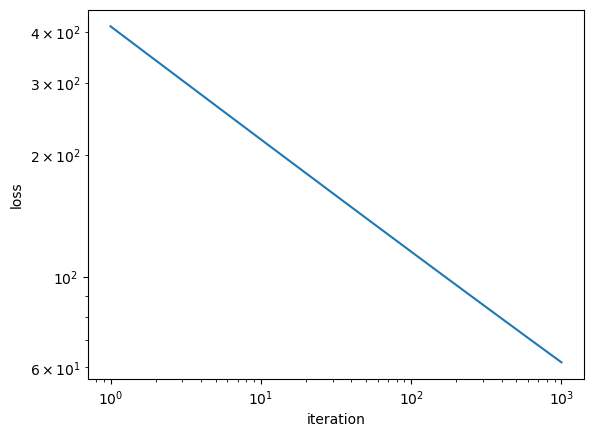

In [34]:
from matplotlib import pyplot as plt

plt.plot(x,y)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.yscale('log')
plt.xscale('log')
plt.show()